# Generating Images to Fool an MNIST Classifier

Despite their high performance on classification tasks such as MNIST, neural networks like the [LeNet-5](https://en.wikipedia.org/wiki/LeNet) have a weakness: they are easy to fool. Namely, given images like the ones below, a classifier may confidently believe that it is seeing certain digits, even though the images look like random noise to humans. Naturally, this phenomenon raises some concerns, especially when the network in question is used in a safety-critical system like a self-driving car. Given such unrecognizable input, one would hope that the network at least has low confidence in its prediction.

![fooling images example](_static/fooling_mnist_example.png)

To make matters worse for neural networks, generating such images is incredibly easy with QD algorithms. As shown in [Nguyen 2015](http://anhnguyen.me/project/fooling/), one can use simple MAP-Elites to generate these images. In this tutorial, we will instead use the pyribs version of MAP-Elites to do just that.

## Setup

First, we install pyribs and PyTorch.

In [ ]:
%pip install ribs torch==1.7 torchvision==0.8

Here, we import PyTorch and some utilities.

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision

Below, we check what device is available for PyTorch. On Colab, activate the GPU by clicking "Runtime" in the toolbar at the top. Then, click "Change Runtime Type", and select "GPU".

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## Preliminary: MNIST Network

For the classifier network, we train a LeNet-5 to classify MNIST. If you are not familiar with PyTorch, we recommend referring to the [PyTorch 60-minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html). On the other hand, if you are familiar, feel free to skip to the next section, where we demonstrate how to fool the network.

**Note**: This section is adapted from the [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) tutorial in the 60-minute blitz.

Before training the network, we load and preprocess the MNIST dataset.

In [4]:
# Transform each image by turning it into a tensor and then
# normalizing the values.
MEAN_TRANSFORM = 0.1307
STD_DEV_TRANSFORM = 0.3081
mnist_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((MEAN_TRANSFORM,), (STD_DEV_TRANSFORM,))
])

TRAIN_BATCH_SIZE = 64
TRAINLOADER = torch.utils.data.DataLoader(torchvision.datasets.MNIST(
    './data', train=True, download=True, transform=mnist_transforms),
                                          batch_size=TRAIN_BATCH_SIZE,
                                          shuffle=True)

TEST_BATCH_SIZE = 1000
TESTLOADER = torch.utils.data.DataLoader(torchvision.datasets.MNIST(
    './data', train=False, transform=mnist_transforms),
                                         batch_size=TEST_BATCH_SIZE,
                                         shuffle=False)

This is our training function. We use negative log likelihood loss and Adam optimization.

In [5]:
def fit(net, epochs):
    """Trains net for the given number of epochs."""
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters())

    for epoch in range(epochs):
        print(f"=== Epoch {epoch + 1} ===")
        total_loss = 0.0

        # Iterate through batches in the shuffled training dataset.
        for batch_i, data in enumerate(TRAINLOADER):
            inputs = data[0].to(device)
            labels = data[1].to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            if (batch_i + 1) % 100 == 0:
                print(f"Batch {batch_i + 1:5d}: {total_loss}")
                total_loss = 0.0

Now, we define the LeNet-5 and train it for 2 epochs. We have annotated the shapes of the data (excluding the batch dimension) as they pass through the network.

In [6]:
LENET5 = nn.Sequential(
    nn.Conv2d(1, 6, (5, 5), stride=1, padding=0),  # (1,28,28) -> (6,24,24)
    nn.MaxPool2d(2),  # (6,24,24) -> (6,12,12)
    nn.ReLU(),
    nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),  # (6,12,12) -> (16,8,8)
    nn.MaxPool2d(2),  # (16,8,8) -> (16,4,4)
    nn.ReLU(),
    nn.Flatten(),  # (16,4,4) -> (256,)
    nn.Linear(256, 120),  # (256,) -> (120,)
    nn.ReLU(),
    nn.Linear(120, 84),  # (120,) -> (84,)
    nn.ReLU(),
    nn.Linear(84, 10),  # (84,) -> (10,)
    nn.LogSoftmax(dim=1),  # (10,) log probabilities
).to(device)

fit(LENET5, 2)

=== Epoch 1 ===
Batch   100: 91.81614878773689
Batch   200: 27.045977912843227
Batch   300: 17.453787453472614
Batch   400: 13.425774186849594
Batch   500: 13.39177893102169
Batch   600: 12.035394479520619
Batch   700: 11.969371708109975
Batch   800: 10.99640073813498
Batch   900: 11.732858279719949
=== Epoch 2 ===
Batch   100: 8.738016366958618
Batch   200: 8.846337342634797
Batch   300: 6.612479413393885
Batch   400: 6.90610909787938
Batch   500: 7.589474496431649
Batch   600: 7.141176660079509
Batch   700: 6.895920315757394
Batch   800: 7.560356660280377
Batch   900: 6.372212674468756


Finally, we evaluate the network on the train and test sets.

In [7]:
def evaluate(net, loader):
    """Evaluates the network's accuracy on the images in the dataloader."""
    correct_per_num = [0 for _ in range(10)]
    total_per_num = [0 for _ in range(10)]

    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.to("cpu"), 1)
            c = (predicted == labels).squeeze()
            for i in range(len(c)):
                label = labels[i]
                correct_per_num[label] += c[i].item()
                total_per_num[label] += 1

    for i in range(10):
        print(f"Class {i}: {correct_per_num[i] / total_per_num[i]:5.3f}"
              f" ({correct_per_num[i]} / {total_per_num[i]})")
    print(f"TOTAL  : {sum(correct_per_num) / sum(total_per_num):5.3f}"
          f" ({sum(correct_per_num)} / {sum(total_per_num)})")

In [8]:
evaluate(LENET5, TRAINLOADER)

Class 0: 0.995 (5895 / 5923)
Class 1: 0.995 (6705 / 6742)
Class 2: 0.989 (5890 / 5958)
Class 3: 0.978 (5997 / 6131)
Class 4: 0.996 (5817 / 5842)
Class 5: 0.992 (5379 / 5421)
Class 6: 0.985 (5831 / 5918)
Class 7: 0.987 (6183 / 6265)
Class 8: 0.909 (5318 / 5851)
Class 9: 0.958 (5699 / 5949)
TOTAL  : 0.979 (58714 / 60000)


In [9]:
evaluate(LENET5, TESTLOADER)

Class 0: 0.998 (978 / 980)
Class 1: 0.997 (1132 / 1135)
Class 2: 0.985 (1017 / 1032)
Class 3: 0.982 (992 / 1010)
Class 4: 1.000 (982 / 982)
Class 5: 0.993 (886 / 892)
Class 6: 0.975 (934 / 958)
Class 7: 0.983 (1011 / 1028)
Class 8: 0.921 (897 / 974)
Class 9: 0.963 (972 / 1009)
TOTAL  : 0.980 (9801 / 10000)


## Fooling the Classifier with MAP-Elites

Above, we trained a reasonably high-performing classifier. In order to fool the classifier into seeing various digits, we use MAP-Elites. As we have 10 distinct digits (0-9), we have a discrete behavior space with 10 values. Note that while pyribs is designed for continuous search spaces, the behavior space can be either continuous or discrete.

Our classifier outputs a log probability vector with its belief that it is seeing each digit. Thus, our objective for each digit is to maximize the probability that the classifier assigns to the image associated with it. For instance, for digit 5, we want to generate an image that makes the classifier believe with high probability that it is seeing a 5.

In pyribs, we implement MAP-Elites with a `GridArchive` and a `GaussianEmitter`. Below, we start by constructing the `GridArchive`. The archive has 10 bins and a range of (0,10). Since `GridArchive` was originally designed for continuous spaces, it does not directly support discrete spaces, but by using these settings, we have a bin for each digit from 0 to 9.

In [10]:
from ribs.archives import GridArchive

archive = GridArchive([10], [(0, 10)])

Next, we use a single Gaussian emitter with batch size of 30. The emitter begins with an image filled with 0.5 (i.e. grey, since pixels are in the range $[0,1]$) and has $\sigma = 0.5$.

In [11]:
from ribs.emitters import GaussianEmitter

img_size = (28, 28)
flat_img_size = 784  # 28 * 28
emitters = [
    GaussianEmitter(
        archive,
        # Start with a grey image.
        np.full(flat_img_size, 0.5),
        0.5,
        # Bound the generated images to the pixel range.
        bounds=[(0, 1)] * flat_img_size,
        batch_size=30,
    )
]

Finally, we construct the optimizer to connect the archive and emitter together.

In [12]:
from ribs.optimizers import Optimizer

optimizer = Optimizer(archive, emitters)

With the components created, we now generate the images. As we use 1 emitter with batch size of 30 and run 30,000 iterations, we evaluate 900,000 images in total.

In [13]:
total_itrs = 30_000
start_time = time.time()

for itr in range(1, total_itrs + 1):
    sols = optimizer.ask()

    with torch.no_grad():

        # Reshape and normalize the image and pass it through the network.
        imgs = sols.reshape((-1, 1, *img_size))
        imgs = (imgs - MEAN_TRANSFORM) / STD_DEV_TRANSFORM
        imgs = torch.tensor(imgs, dtype=torch.float32, device=device)
        output = LENET5(imgs)

        # The BC is the digit that the network believes it is seeing, i.e. the
        # digit with the maximum probability. The objective is the probability
        # associated with that digit.
        scores, predicted = torch.max(output.to("cpu"), 1)
        scores = torch.exp(scores)
        objs = scores.numpy()
        bcs = predicted.numpy()

    optimizer.tell(objs, bcs)
    
    if itr % 1000 == 0:
        print(f"Iteration {itr} complete after {time.time() - start_time} s")

Iteration 1000 complete after 10.027801752090454 s
Iteration 2000 complete after 17.346381187438965 s
Iteration 3000 complete after 25.372213125228882 s
Iteration 4000 complete after 33.184513092041016 s
Iteration 5000 complete after 39.56904053688049 s
Iteration 6000 complete after 46.14599132537842 s
Iteration 7000 complete after 53.737348318099976 s
Iteration 8000 complete after 62.2300922870636 s
Iteration 9000 complete after 72.80587482452393 s
Iteration 10000 complete after 82.70882964134216 s
Iteration 11000 complete after 89.18955159187317 s
Iteration 12000 complete after 95.09450602531433 s
Iteration 13000 complete after 101.04468393325806 s
Iteration 14000 complete after 106.959787607193 s
Iteration 15000 complete after 112.8634295463562 s
Iteration 16000 complete after 118.76160025596619 s
Iteration 17000 complete after 124.70901298522949 s
Iteration 18000 complete after 130.61263966560364 s
Iteration 19000 complete after 136.4743263721466 s
Iteration 20000 complete after 14

Below, we display the images found. Interestingly, though the images look mostly like noise, we can occasionally make out traces of the original digit. Note that MAP-Elites may not find images for all the digits, and this is mostly due to the small behavior space. Usually, QD algorithms run with fairly large behavior spaces. This is something to keep in mind when tuning QD algorithms.

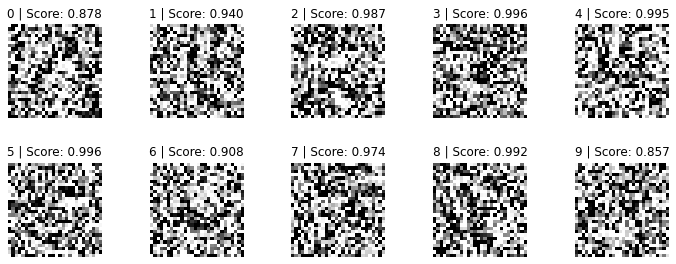

In [14]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
fig.tight_layout()
ax = ax.flatten()
found = set()

# Display images.
for sol, obj, beh, idx, _ in zip(*archive.data()):
    digit = idx[0]
    found.add(digit)

    # No need to normalize image because we want to see the original.
    ax[digit].imshow(sol.reshape(28, 28), cmap="Greys")
    ax[digit].set_axis_off()
    ax[digit].set_title(f"{digit} | Score: {obj:.3f}", pad=8)

# Mark digits that we did not generate images for.
for digit in range(10):
    if digit not in found:
        ax[digit].set_title(f"{digit} | (no solution)", pad=8)
        ax[digit].set_axis_off()

## Conclusion

In this tutorial, we used MAP-Elites to generate images that fool a LeNet-5 MNIST classifier. For further exploration, we recommend referring to [Nguyen 2015](http://anhnguyen.me/project/fooling/) and replicating or extending the other experiments described in the paper.

## Citation

If you find this tutorial useful, please cite it as:

```text
@article{pyribs_fooling_mnist,
  title   = {Generating Images to Fool an MNIST Classifier},
  author  = {Bryon Tjanaka and Matthew C. Fontaine and Stefanos Nikolaidis},
  journal = {pyribs.org},
  year    = {2021},
  url     = {https://docs.pyribs.org/en/stable/tutorials/fooling_mnist.html}
}
```